# Basic Logistic Regression in Pytorch

In [37]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

import torch


## Import data

In [38]:
from torchvision import datasets, transforms

# Don't need to do type hints in prod
mnist_train: torch.utils.data.Dataset = datasets.MNIST(root="./datasets", 
                                                       train=True, 
                                                       transform=transforms.ToTensor(), 
                                                       download=True)

mnist_test: torch.utils.data.Dataset = datasets.MNIST(root="./datasets", 
                                                      train=False, 
                                                      transform=transforms.ToTensor(), 
                                                      download=True)

print(f"No. of MNIST training examples: {len(mnist_train)}")
print(f"No. of MNIST test examples: {len(mnist_test)}")

No. of MNIST training examples: 60000
No. of MNIST test examples: 10000


## Plotting and manipulating the data

Image shape: torch.Size([1, 28, 28]) This means that there is 1 channel, with 28x28 pixels
Reshaped image: torch.Size([28, 28])
Label: 1


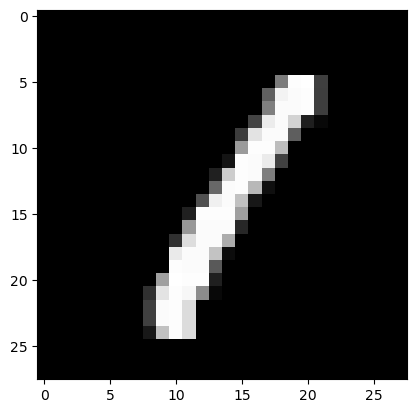

In [39]:
# Pick an arbitrary item from the training dataset
image, label = mnist_train[3]

# Plot the imagine
print(f"Image shape: {image.shape}", "This means that there is 1 channel, with 28x28 pixels")

image = image.reshape((28, 28))
print(f"Reshaped image: {image.shape}")

print(f"Label: {label}")

plt.imshow(image, cmap="gray")
plt.show()

## Using the dataloader

Images shape: torch.Size([100, 1, 28, 28])
Labels shape: torch.Size([100])
Image type: <class 'torch.Tensor'>
Label type: <class 'torch.Tensor'>


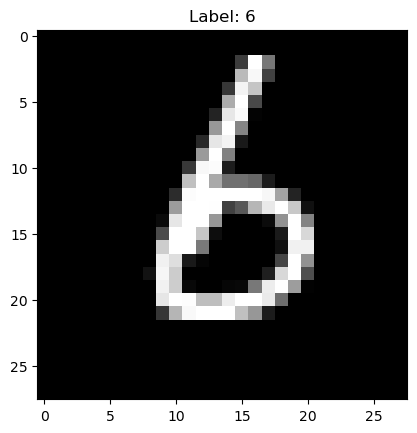

In [40]:
train_loader = torch.utils.data.DataLoader(mnist_train, 
                                           batch_size=100, 
                                           shuffle=True)
test_loader = torch.utils.data.DataLoader(mnist_test, 
                                          batch_size=100, 
                                          shuffle=False)
# print(type(train_loader))

# Get the first batch from the DataLoader
images, labels = next(iter(train_loader))

# Print shape and types
print(f"Images shape: {images.shape}")  # (batch_size, channels, height, width)
print(f"Labels shape: {labels.shape}")  # (batch_size,)
print(f"Image type: {type(images)}")    # torch.Tensor
print(f"Label type: {type(labels)}")    # torch.Tensor

plt.imshow(images[0].squeeze(), cmap="gray")  # Remove channel dim for visualization
plt.title(f"Label: {labels[0].item()}")
plt.show()

## Inference

In [41]:
input_size = 28 * 28
classes = 10


# Randomly initialize weights using "Xavier initiallization"
# 2 line initialization because the "/ np.sqrt" makes it a non-leaf tensor
W = torch.randn(input_size, classes) / np.sqrt(input_size)
W.requires_grad_()
b = torch.zeros(10, requires_grad=True)

# flatten the input
x = images.view(-1, input_size)

# Inference
y_prime = x @ W + b # torch.matmul
print(y_prime[0, :])

# Softmax dat bih
import torch.nn.functional as F
y_hat = F.softmax(y_prime, dim=1)
print(y_hat[0, :])

tensor([ 0.1489, -1.0728, -0.2871, -0.0339,  0.0227,  0.0877, -0.2929, -0.0876,
         0.1734,  0.3395], grad_fn=<SliceBackward0>)
tensor([0.1210, 0.0357, 0.0782, 0.1008, 0.1067, 0.1138, 0.0778, 0.0955, 0.1240,
        0.1464], grad_fn=<SliceBackward0>)


## Learning

### Cross-entropy loss (aka minus log likelihood)

We defined it as "negative average log of the probability of the true label being yi given a prediction y_hat"

In [42]:
# This expects y_hat to already be softmaxed
def cross_entropy(y_hat, y):
    batch_size = y_hat.shape[0]
    log_probs = -torch.log(y_hat[range(batch_size), y]) # some fancy indexing
    return log_probs.mean()

print(f"Cross entropy from equation: {cross_entropy(y_hat, labels)}")
print(f"Cross entropy from library: {F.cross_entropy(y_prime, labels)}")

Cross entropy from equation: 2.298966646194458
Cross entropy from library: 2.298966407775879


### Back propagation

In [43]:
# Behind the scenes, all the computations for this loss are tracked by 
# torch's tensor computation graph, allowing for "autograd" features
loss = cross_entropy(y_hat, labels)
optimizer = torch.optim.SGD([W, b], lr=0.1)

# Propagate the loss backwards through the computation graph
loss.backward()
print("gradient for b: ", b.grad)
# Apply the gradient to 
optimizer.step()
print("new values for b: ", b)
optimizer.zero_grad() # clear the buffers for the numerical gradients

gradient for b:  tensor([-0.0075, -0.0478,  0.0186, -0.0292,  0.0100,  0.0132, -0.0536,  0.0876,
         0.0485, -0.0398])
new values for b:  tensor([ 0.0008,  0.0048, -0.0019,  0.0029, -0.0010, -0.0013,  0.0054, -0.0088,
        -0.0049,  0.0040], requires_grad=True)


## Iterative Training

In [44]:
for images, labels in tqdm(train_loader):
    optimizer.zero_grad()
    
    x = images.view(-1, input_size)
    y_hat = x @ W + b # compute raw logits

    loss = F.cross_entropy(y_hat, labels)
    
    loss.backward()
    optimizer.step()

  0%|          | 0/600 [00:00<?, ?it/s]

## Testing

In [45]:
correct = 0
total = len(mnist_test) # type: ignore

with torch.no_grad():
    for images, labels in tqdm(test_loader):
        x = images.view(-1, input_size)
        y = x @ W + b
        
        y_pred = torch.argmax(y, dim=1)
        correct += torch.sum((y_pred == labels).float())

print(f"Test accuracy: {correct/total}")

  0%|          | 0/100 [00:00<?, ?it/s]

Test accuracy: 0.9006999731063843


## Visualizing weights

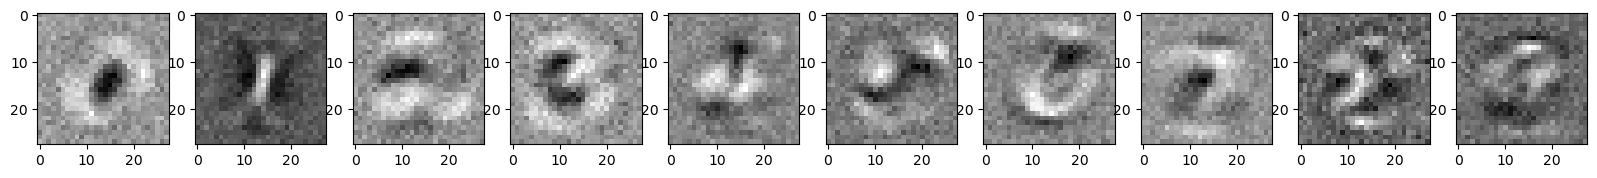

In [49]:
fig, ax = plt.subplots(1, 10, figsize=(20, 2))

for digit in range(10):
    ax[digit].imshow(W[:,digit].detach().view(28,28), cmap='gray')

plt.show()